# Bayesian MBG Predictions (batched)

In [1]:
import functions

import pymc as pm

import os
import pickle
import numpy as np
import arviz as az
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
import pytensor.tensor as at

import uuid
import pytensor.tensor as at
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


## Geostatistical Modeling

### Parameters

In [2]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [3]:
#Define the directory where the pickle files are stored
pickle_dir = 'temp_files'

target_indicator = report['Target Indicator']

# Get the number of CPU cores to max out the machine in the traning stage
num_cores = os.cpu_count()

print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 8


### Load target and covariates

In [4]:
gdf = pd.read_pickle('temp_files/selected_features.pkl')

In [5]:
selected_features = gdf.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [6]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry])

#Standardize
coordinates = scaler.fit_transform(coordinates)

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[~gdf[target_indicator].isnull()].geometry])

# Standardize
coordinates_observed = scaler.fit_transform(coordinates_observed)

In [7]:
#Only rows with observed target indicator
df1 = gdf[~gdf[target_indicator].isnull()]

In [8]:
# Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(df1[[target_indicator]])

#Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

Skewness: [0.42578133], Kurtosis: [-0.57610397]
No transformation applied due to low skewness and non-positive values.


In [9]:
#Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [10]:
# Transformed target variable
y = df1[target_indicator].values

In [11]:
# Covariate matrix
X = df1[selected_features].values

In [12]:
# Standardize features and transformed y

scaler_x = MinMaxScaler()
X = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [24]:
# Save the scaler to a pickle file
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

### Recreate the saved model

In [13]:
# After fitting the model
trace_filename = 'model_trace.nc'

In [14]:
#Load the model
idata = az.from_netcdf(trace_filename)

# Re-create the model
with pm.Model() as model:
    # Re-create the model's priors and components
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    sigma = pm.HalfNormal('sigma', sigma=1)
    ls = pm.HalfCauchy('ls', beta=0.5)

    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    K = pm.gp.cov.Matern52(2, ls=ls)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=coordinates_observed)

    mu = pm.math.dot(X, beta) + f
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

## Preprocessing New Covariates data

In [14]:
#gdf2 = gdf[gdf[target_indicator].isnull()] #Activate this to exclude the 

#DF with all observations
gdf2 = gdf.copy(deep=True)
df2 = gdf2.copy(deep=True)
df2.reset_index(drop=True, inplace=True)

# Extract coordinates from the geometry column (using centroid for Polygons) only for unobserved rows
coordinates_new = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf2.geometry])

# Standardize
coordinates_new = scaler.fit_transform(coordinates_new)

# Covariate matrix
X_new = df2[selected_features].values

# Standardize the new data using the same scaler fitted on the observed data
X_new = scaler_x.transform(X_new)

In [15]:
df3 = pd.DataFrame(X_new, columns=selected_features)

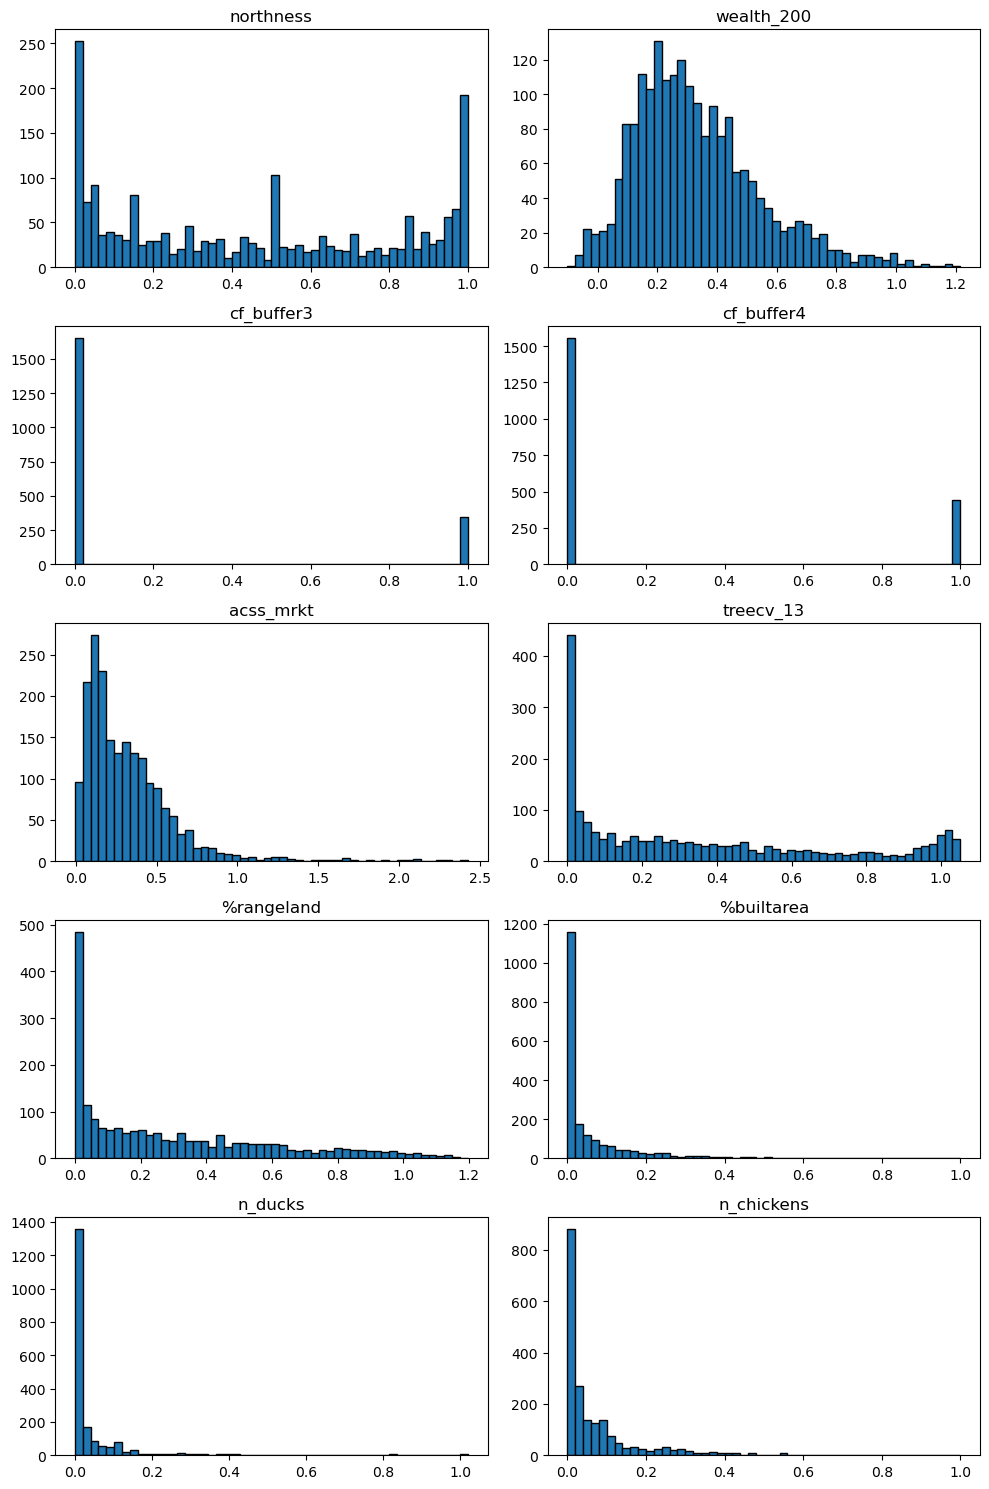

In [16]:
# Visualize distributions of covariates
functions.plot_histograms(df3, bins=50)

## Predictions

### Loading the new model

In [17]:
# Load the model
idata = az.from_netcdf(trace_filename)

# Re-create the model
with pm.Model() as model:
    # Re-create the model's priors and components
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    sigma = pm.HalfNormal('sigma', sigma=1)
    ls = pm.HalfCauchy('ls', beta=0.5)

    # Distance matrix for the GP kernel
    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    # Define the covariance function (Matern52 with jitter for numerical stability)
    K = pm.gp.cov.Matern52(2, ls=ls)
    
    # Define the GP latent model
    gp = pm.gp.Latent()
    f = gp.prior('f', X=coordinates_observed)

    # Linear combination of covariates and GP
    mu = pm.math.dot(X, beta) + f
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)



In [18]:
def generate_predictions_no_noise(model, coordinates_new, X_new, idata):
    """
    Generate predictions for new data using a Gaussian Process model, leveraging
    the posterior mean for making predictions. This version does NOT add noise to the predictions.
    
    Returns:
    - mean_predictions: The predicted mean for each data point (without noise).
    """
    with model:
        unique_name = "f_pred_" + str(uuid.uuid4())

        # Generate the conditional GP for the new locations (provides mean and variance)
        f_pred = gp.conditional(unique_name, coordinates_new)

        # Extract the posterior mean for all variables
        posterior_mean = {var: idata.posterior[var].mean(dim=["chain", "draw"]).values for var in idata.posterior.data_vars}

        # Generate posterior predictive samples for the GP predictions
        pred_samples = pm.sample_posterior_predictive(idata, var_names=[unique_name], return_inferencedata=True)
        
        # Get the mean and variance for the GP predictions
        f_pred_mean = pred_samples.posterior_predictive[unique_name].mean(axis=0)
        f_pred_var = pred_samples.posterior_predictive[unique_name].var(axis=0)
        
        # Compute the mean of the beta samples (from posterior)
        beta_mean = posterior_mean['beta']

        print("beta_mean:", beta_mean)  # Should be around the scale of the standardized covariates

        # Compute the linear term for the new data points
        lin_pred = np.dot(X_new, beta_mean)

        # Add the linear term to the GP prediction mean
        mean_predictions = lin_pred + f_pred_mean

        return mean_predictions


In [19]:
begin_from_scratch = True
    
if begin_from_scratch == True: 
    #Dataframe to store predictions and other values for uncertainty calculations
    df3 = pd.DataFrame(df2[['grid_id', 'mpi']].head(0))
    start_position=0

else:
    #Pick-up productions were we left of. 
    with open('temp_files/predictions.pkl', 'rb') as pickle_file:
        df3 = pickle.load(pickle_file)
    start_position = df3.index.max() + 1

In [20]:
start_position

0

In [21]:
# Assuming 95% confidence level, change alpha for different confidence levels
alpha = 0.05
z_score = stats.norm.ppf(1 - alpha/2)

In [22]:
#step = 434
step = 100

In [23]:
for i in range(start_position, len(df2)-1, step):

    r = range(i, i+step)
    
    print(r)
    
    X_new_i = X_new[r]
    
    coordinates_new_i = coordinates_new[r]
    
    #predictions_i = generate_predictions(model, coordinates_new_i, X_new_i, idata, max_attempts=2)

    predictions_i = generate_predictions_no_noise(model, coordinates_new_i, X_new_i, idata)
    
    # Extracting relevant data
    dfi = df2.loc[r][['grid_id', target_indicator]]
    dfpi = pd.DataFrame(predictions_i)
    
    # Calculating mean, standard deviation, and other statistics
 
    dfi[target_indicator] = dfpi.mean().values  # Mean prediction for each observation
    dfi['std'] = dfpi.std().values              # Standard deviation for each observation
    dfi['max'] = dfpi.max().values              # Max prediction for each observation
    dfi['min'] = dfpi.min().values              # Min prediction for each observation
     
    # Calculating the margin of error for the confidence interval
    dfi['standard_error'] = dfi['std'] / (len(dfpi)**0.5)
    dfi['margin_of_error'] = z_score * dfi['standard_error']
    
    # Calculating the confidence interval
    dfi['ci_lower'] = dfi[target_indicator] - dfi['margin_of_error']
    dfi['ci_upper'] = dfi[target_indicator] + dfi['margin_of_error']
    
    df3 = pd.concat([df3, dfi])

    #Save predictions so far
    df3.to_pickle('temp_files/predictions.pkl')


range(0, 100)


Sampling: [f_pred_e493cb9c-7680-4646-8770-60b976c100a4]


Output()

Sampling: [f_pred_0de45788-6085-47f2-9bbe-a7122d0c8617]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(100, 200)


Sampling: [f_pred_a8413f37-6014-4404-b8ff-66f351290ddf]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(200, 300)


Sampling: [f_pred_0ad36622-a155-4220-8c77-7971e93691d0]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(300, 400)


Sampling: [f_pred_a04b2a14-8341-483f-8d30-2036c78541c1]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(400, 500)


Sampling: [f_pred_d319b829-588c-46ea-a522-81df2633af82]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(500, 600)


Sampling: [f_pred_c381d8ae-4020-4b03-9461-93829051bf9b]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(600, 700)


Sampling: [f_pred_ecf536a2-8956-405e-860d-24df729ab1b7]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(700, 800)


Sampling: [f_pred_a1a9f638-12c1-44de-8064-ac6317db7bf5]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(800, 900)


Sampling: [f_pred_116de7d3-d0a1-45df-a777-9de6d95a73ba]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(900, 1000)


Sampling: [f_pred_a161ec1f-1dd1-44d7-a3a5-866a7dced224]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1000, 1100)


Sampling: [f_pred_c13d8c2b-414c-4bbb-b37b-c6efe5a8c60d]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1100, 1200)


Sampling: [f_pred_b18e6b1f-7940-4255-9e52-b921388fb8d8]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1200, 1300)


Sampling: [f_pred_314af131-6fad-42e9-942a-8711c469b9a5]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1300, 1400)


Sampling: [f_pred_f42c6813-9238-42bd-99c6-0a826960618f]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1400, 1500)


Sampling: [f_pred_60083c36-65c5-47b1-b219-321396daa255]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1500, 1600)


Sampling: [f_pred_b14f7c45-9949-4848-a361-591a2e6d37f8]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1600, 1700)


Sampling: [f_pred_bdc73eaf-88a6-4474-9e42-e690f788962f]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1700, 1800)


Sampling: [f_pred_13db4894-b3bd-4a6b-8e9c-95d54acdfe9e]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1800, 1900)


Sampling: [f_pred_a665b908-0418-49d9-a052-c690ab5554f2]


Output()

beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
range(1900, 2000)


beta_mean: [ 0.09560317 -0.45860981 -0.1574795   0.14987693  0.26836283 -0.02435481
  0.08915777 -0.18027226 -0.26925787 -0.12535894]
